# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [27]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Model Choice

As a baseline we chose the model that performed best in the [COLET: A dataset for COgnitive workLoad estimation based on eye-tracking](https://www.sciencedirect.com/science/article/pii/S0169260722003716) paper. It was a Gaussian Naive Bayes (GNB) classifier. GNBs are traditional machine learning models. This offers a good starting point to compare them to the newer and more complex deep neural network architectures.


## Feature Selection

In [3]:
# Load the dataset
import os 

data_folder = '../data/'
dataset_path = os.path.join(data_folder, 'preprocessed_df_v2.csv')
df = pd.read_csv(dataset_path)

# Merge participant data with dataset on participant_id
participants_path = os.path.join(data_folder, 'participants.csv')
participants_df = pd.read_csv(participants_path)
df = pd.merge(df, participants_df, left_on='participant_id', right_on='ID', how='left')

# Rename columns & make lowercase
df.rename(columns={
    'VisualAcuity_logMAR_': 'visual_acuity',
    'Gender': 'gender',
    'Age': 'age',
    'Education': 'education'
}, inplace=True)


df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,...,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,ID,visual_acuity,gender,age,education
0,1,1,33.643950,10,5,15,25,25,10,15.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,-0.04,F,28,18
1,1,2,28.484322,50,30,25,50,15,25,32.5,...,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,1,-0.04,F,28,18
2,1,3,71.423823,100,10,75,80,90,20,62.5,...,-33.765546,0.848925,1.935731,0.897654,2.045050,1,-0.04,F,28,18
3,1,4,38.163442,60,15,45,50,20,25,35.8,...,-2.596309,1.906622,4.347507,1.951494,4.445927,1,-0.04,F,28,18
4,2,1,41.748047,20,10,20,10,20,15,15.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,2,-0.10,F,28,18


## Relevant Features

We'll use the mean cognitive load as the output we want to predict. Therefore we can drop the following features: 'mental', 'physical', 'temporal', 'performance', 'effort', 'frustration'. Furthermore we can remove the 'participant_id'/'ID' as well as the 'test_id' as they are not relevant for the prediction.

Label:
- mean

Features:
- gender
- age
- education
- visual_acuity
- test_duration
- blinkrate (per second)
- fixationrate (per second)
- mean_pupil_diameter
- median_pupil_diameter
- blinkrate_rel (relative change to baseline)
- blinkrate_rel_pct (relative change to baseline in percent)
- fixationrate_rel
- fixationrate_rel_pct
- mean_pupil_diameter_rel
- mean_pupil_diameter_rel_pct
- median_pupil_diameter_rel
- median_pupil_diameter_rel_pct

In [4]:
# Drop not needed features
columns_to_drop = ['mental', 'physical', 'temporal', 'performance', 'effort', 
                   'frustration', 'participant_id', 'ID', 'test_id']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,test_duration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity,gender,age,education
0,33.643950,15.0,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,F,28,18
1,28.484322,32.5,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,F,28,18
2,71.423823,62.5,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,F,28,18
3,38.163442,35.8,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,F,28,18
4,41.748047,15.8,31.492393,31.393101,0.000000,0.143727,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,F,28,18


In [5]:
# Check dataset for NaN values
df.isna().sum()

test_duration                     0
mean                              0
mean_pupil_diameter               0
median_pupil_diameter             0
blinkrate                         0
fixationrate                      0
blinkrate_rel                     0
blinkrate_rel_pct                52
fixationrate_rel                  0
fixationrate_rel_pct              0
mean_pupil_diameter_rel           0
mean_pupil_diameter_rel_pct       0
median_pupil_diameter_rel         0
median_pupil_diameter_rel_pct     0
visual_acuity                     0
gender                            0
age                               0
education                         0
dtype: int64

In [6]:
# Remove NaN values that happen only in blinkrate_rel_pct, which is the relative change of the blinkate (in percentage) to the baseline.
# If the baseline is 0, the relative change is NaN. In this case we replace NaN with 0 as there's no change.
df['blinkrate_rel_pct'] = df['blinkrate_rel_pct'].fillna(0)

# validate
df.isna().sum()

test_duration                    0
mean                             0
mean_pupil_diameter              0
median_pupil_diameter            0
blinkrate                        0
fixationrate                     0
blinkrate_rel                    0
blinkrate_rel_pct                0
fixationrate_rel                 0
fixationrate_rel_pct             0
mean_pupil_diameter_rel          0
mean_pupil_diameter_rel_pct      0
median_pupil_diameter_rel        0
median_pupil_diameter_rel_pct    0
visual_acuity                    0
gender                           0
age                              0
education                        0
dtype: int64

In [7]:
# Binary / Categorical encoding of features and labels
def categorize_mean_simple(value):
    if value <= 50:
        return 'low'
    else:
        return 'high' 

def categorize_mean(value):
    if value <= 33:
        return 'low'
    elif value <= 66:
        return 'mid'
    else:
        return 'high'

df['gender'] = df['gender'].map({'F': 0, 'M': 1})
df['mean'] = df['mean'].apply(categorize_mean)

df.head()

,test_duration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity,gender,age,education
0,33.643950,low,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0,28,18
1,28.484322,low,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,0,28,18
2,71.423823,mid,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,0,28,18
3,38.163442,mid,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,0,28,18
4,41.748047,low,31.492393,31.393101,0.000000,0.143727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,0,28,18


In [14]:
# Extract labels and create tain, test, validation sets
X = df.drop(['mean'], axis=1)
y = df['mean'] # mean is the mean cognitive workload we want to predict

# Encode labels, sci-kit learn can internally handle strings, but we convert them anyways for good practice
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Few examples of the encoded labels
for original, encoded in zip(y[:10], y_encoded[:10]):
    print(f"Original Label: '{original}', Encoded Label: {encoded}")

Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'mid', Encoded Label: 2
Original Label: 'mid', Encoded Label: 2
Original Label: 'low', Encoded Label: 1
Original Label: 'mid', Encoded Label: 2
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1


<Axes: xlabel='mean'>

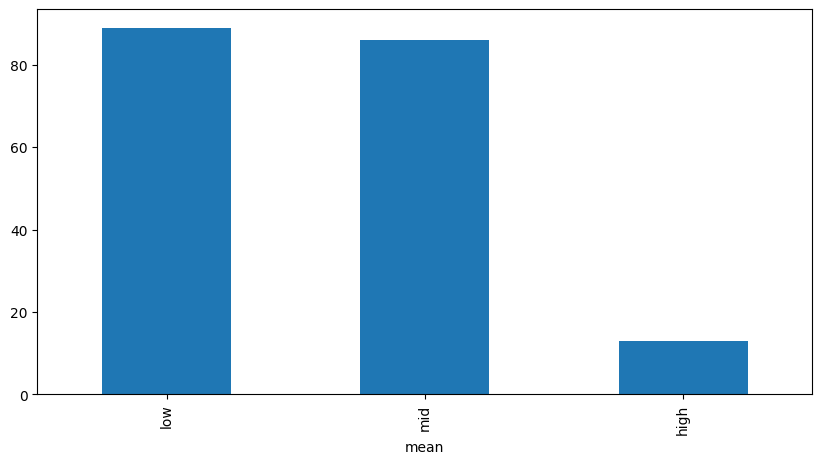

In [22]:
# Quick look at the balance of the data
df['mean'].value_counts().plot.bar(figsize=(10, 5))

In [15]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

# Further split the training data to create a validation set (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
validation_samples = X_val.shape[0]

print(f"Training Set Samples: {X_train.shape[0]}")
print(f"Testing Set Samples: {X_test.shape[0]}")
print(f"Validation Set Samples: {X_val.shape[0]}")

Training Set Samples: 120
Testing Set Samples: 38
Validation Set Samples: 30


## Baseline Model - Gaussian Naive Bayes Classifier (GNB)

In [17]:
# Training the Gaussian Naive Bayes classifier again with encoded labels
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

## Evaluation

In [29]:
# Evaluate the baseline model
y_val_pred = gnb.predict(X_val)

# Calculate accuracy: proportion of total correct predictions
accuracy_val = accuracy_score(y_val, y_val_pred)

# Calculate precision: proportion of correct positive predictions
precision_val = precision_score(y_val, y_val_pred, average='weighted')

# Calculate recall: proportion of actual positives identified
recall_val = recall_score(y_val, y_val_pred, average='weighted')

# Calculate F1 score: weighted average of precision and recall
f1_val = f1_score(y_val, y_val_pred, average='weighted')

# Generate confusion matrix: a summary of prediction results on a classification problem
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Print the results
print('Accuracy:', accuracy_val)
print('Precision:', precision_val)
print('Recall:', recall_val)
print('F1 Score:', f1_val)

Accuracy: 0.6333333333333333
Precision: 0.7777777777777779
Recall: 0.6333333333333333
F1 Score: 0.6575757575757576


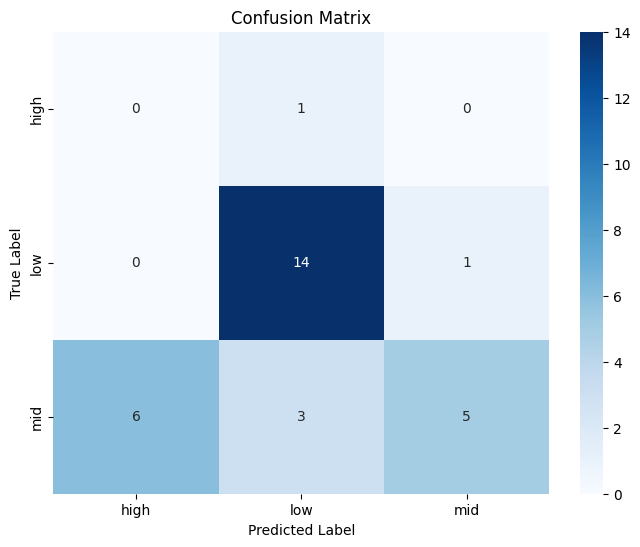

In [ ]:
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Key takeaways:
- The model struggles with identifying 'high', as it has not correctly predicted this class even once.
- There's a noticeable issue with 'mid' being misclassified as both 'high' and 'low'.
- The best performance is in predicting 'low', which it does correctly most of the time, but there is still room for improvement in distinguishing 'low' from 'mid'.

'low' and 'mid' are pretty much balanced, however 'high' is quite underrepresented which is a problem.